In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'RdBu'
import numpy as np
import scipy.cluster.hierarchy as hier
import csv
from bs4 import BeautifulSoup
import urllib
import re
import string

import pdb

In [29]:
# import terms from Pubmed scrape data
import pandas
counts = pandas.read_csv('./data/term_counts_pubmed.csv')
terms = [t for t in counts['term'][1:]]
len(terms)

803

In [30]:
def scrape_CS(home_url, terms):
    #connect to home url
    CSurl = urllib.urlopen(home_url + 'index.html').read()
    soup = BeautifulSoup(CSurl, 'html.parser')
    all_links = soup.find_all('a', attrs={'href': re.compile("papers/*")})

    #initialize pair matrix and doc-word matrix
    pair_mat = np.zeros((len(terms), len(terms)))
    doc_mat = np.zeros((len(all_links), len(terms)))
    
    # enumerate through all links
    for link_idx, link in enumerate(all_links):
        # get soup from paper url
        if home_url not in str(link['href']):
            url_text = home_url + str(link['href'])
        else:
            url_text = str(link['href'])
    
        #print url_text
        url = urllib.urlopen(url_text).read()
        soup = BeautifulSoup(url, 'html.parser')
    
        # get title & abstract as a single string
        title = soup.find_all('h1')[0].text.encode('utf-8').lower().split()
        

        if '2014' in home_url:
            #exception rule for 2014
            abstr = soup.find_all('blockquote')[1].text.encode('utf-8').lower().split()
        else:            
            abstr = soup.find_all(('p'),attrs={'id':'abstract'})[0].text.encode('utf-8').lower().split()
        
        sen = ' '.join(title + ['+'] + abstr) #separate abstract and title with +
        term_pos = []
        for idx, t in enumerate(terms):
            if t in sen:
                term_pos.append(idx)
                doc_mat[link_idx,idx] = 1
    
        if len(term_pos)>0:
            for t1 in term_pos:
                for t2 in term_pos:
                    pair_mat[t1,t2] += 1

    
    return pair_mat, doc_mat

In [32]:
# get all paper links from cogsci conference
home_urls = ['https://mindmodeling.org/cogsci2016/',
             'https://mindmodeling.org/cogsci2015/',
             'https://mindmodeling.org/cogsci2014/',
             'https://mindmodeling.org/cogsci2013/',
             'https://mindmodeling.org/cogsci2012/',
             'https://mindmodeling.org/cogsci2011/',
             'https://mindmodeling.org/cogsci2010/']

all_pairs = []
all_docs = []
for year in home_urls:
    print year
    pairs, docs = scrape_CS(home_url=year, terms=terms)
    all_pairs.append(pairs)
    all_docs.append(docs)

https://mindmodeling.org/cogsci2016/


KeyboardInterrupt: 

In [27]:
# save all the data
np.save('./data/CS_pairs', all_pairs)
np.save('./data/CS_docterm', all_docs)
np.savetxt('./data/pair_count_CS.csv', np.sum(all_pairs, axis=0), delimiter=',')

# save term counts, with total # of docs as first column
CS_counts = np.append(np.sum([np.shape(d)[0] for d in all_docs]),np.diag(np.sum(all_pairs, axis=0)))
np.savetxt('./data/term_counts_CS.csv', CS_counts, delimiter=',')

In [44]:
plt.figure(figsize=(10,10))
# for ap in all_pairs:
#     plt.plot(np.diag(ap))
diags = ([np.diag(ap) for ap in all_pairs])
np.sum(np.sum(diags,axis=0)>0)

478

In [396]:
idx = np.argsort(pair_mat.diagonal())
print [(terms_5p[i], pair_mat.diagonal()[i]) for i in idx[-1:-20:-1]]

[('search', 163.0), ('learning', 161.0), ('action', 142.0), ('language', 134.0), ('logic', 104.0), ('knowledge', 90.0), ('concept', 85.0), ('decision', 79.0), ('memory', 71.0), ('context', 70.0), ('judgment', 68.0), ('focus', 60.0), ('inference', 58.0), ('lying', 58.0), ('meaning', 56.0), ('attention', 55.0), ('reasoning', 52.0), ('movement', 48.0), ('perception', 46.0)]


In [398]:
X = pair_mat
X_norm = np.zeros(np.shape(X))
for idx in range(np.shape(X)[0]):
    if X[idx,idx]>0:
        X_norm[idx,:] = X[idx,:]/X[idx,idx]

#np.savetxt('paircountnorm_CS16.csv', X_norm, delimiter=',')

In [399]:
[terms_5p[idx] for idx in np.argsort(X[terms_5p.index('working memory'),:])[-1:-30:-1]]

['memory',
 'working memory',
 'learning',
 'resource',
 'skill',
 'logic',
 'search',
 'action',
 'recall',
 'knowledge',
 'spatial working memory',
 'concept',
 'schema',
 'context',
 'retrieval',
 'sentence processing',
 'attention',
 'chunking',
 'visual working memory',
 'reading',
 'lying',
 'language',
 'chunk',
 'perception',
 'spatial ability',
 'uncertainty',
 'updating',
 'coordination',
 'emotion']

In [442]:
# get jacard index
X = pair_mat
jacardD = np.zeros(np.shape(X))
for i in range(len(terms_5p)):
    for j in range(len(terms_5p)):
        if X[i,j] != 0:            
            jacardD[i,j] = X[i,j]/(X[i,i]+X[j,j]-X[i,j])
#            jacardD[i,j] = (X[i,i]+X[j,j]-X[i,j])/X[i,j]
#            jacardD[j,j] = 0.

([<matplotlib.axis.XTick at 0x167487150>,
 <a list of 15 Text xticklabel objects>)

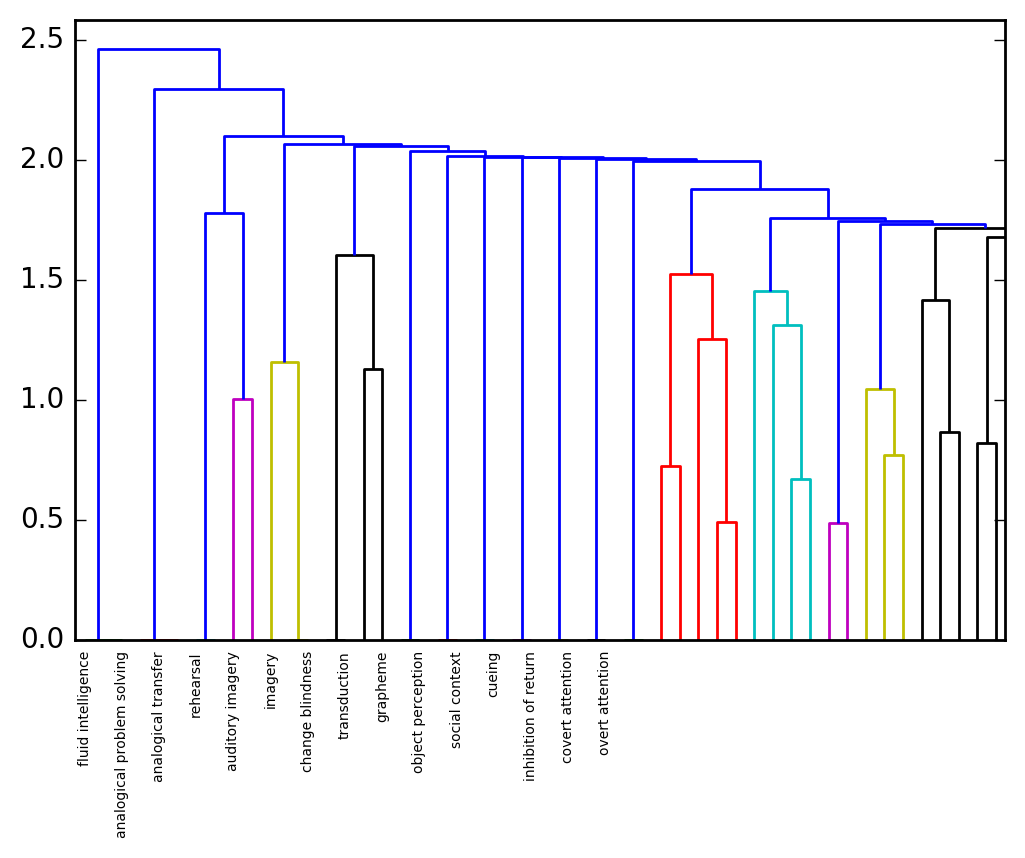

In [504]:
Y = clhi.linkage(jacardD,method='complete')
Z = clhi.dendrogram(Y)
#plt.imshow(jacardD[Z['leaves'],:])
plt.xlim((0,500))
plt.xticks(np.arange(5,500,20),[terms_5p[z] for z in Z['leaves'][:15]])
#plt.xticks()

['fluid intelligence',
 'analogical problem solving',
 'analogical transfer',
 'rehearsal',
 'auditory imagery',
 'imagery',
 'change blindness',
 'transduction',
 'grapheme',
 'object perception',
 'social context',
 'cueing',
 'inhibition of return',
 'covert attention',
 'overt attention']

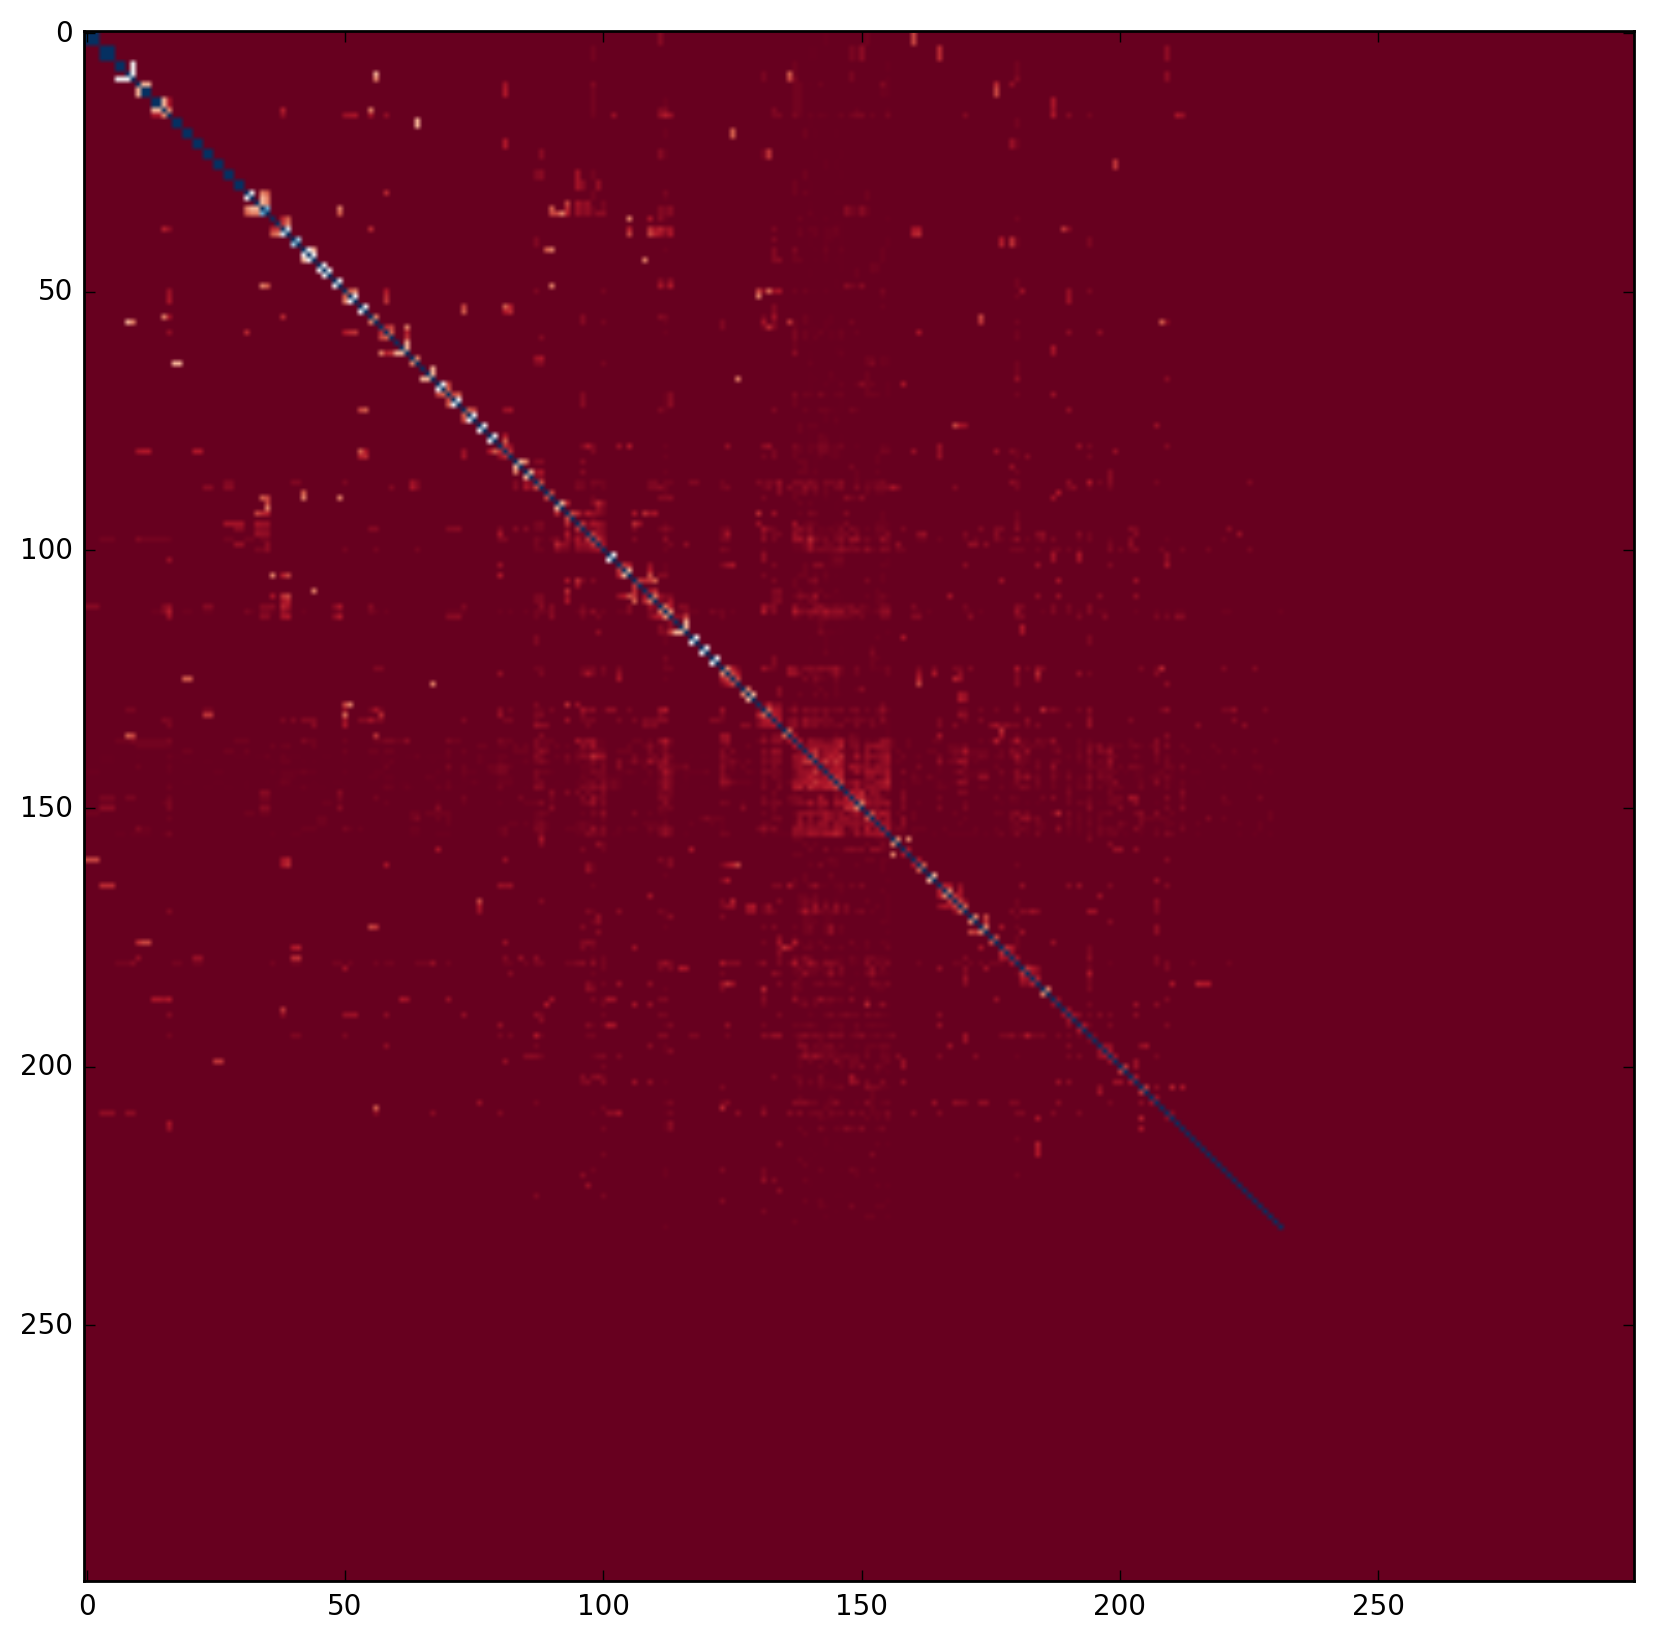

In [445]:
D2 = jacardD[Z['leaves'],:]
D2 = D2[:,Z['leaves']]
plt.figure(figsize=(10,10))
plt.imshow(D2[:300, :300])
#terms_re = [terms_5p[z] for z in Z['leaves']]

In [468]:
from sklearn.cluster import SpectralClustering
classes = SpectralClustering(20).fit_predict(jacardD)

In [491]:
[terms_5p[idx] for idx in np.where(classes==20)[0]]

[]

###### 